# LWP budget analysis for ASTEX stratocumulus-to-cumulus transition

### by Youtong Zheng, Univ. of Maryland, Aug 25, 2020

The framework is based on the equation from van der Dussen et al., 2014:

\begin{equation*}
\frac{dLWP}{dt}  = Ent + Base + Rad + Prec + Sub
\end{equation*}

In [41]:
# setting up everything
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import seaborn as sns

from matplotlib import cm
%matplotlib inline

In [4]:
# define constants
# Const
Rd     = 287.              # Gas constant for dry air, J/kg/K
Rv     = 461.              # Gas constant for water vapor, J/kg/K
cp     = 1004.             # Specific heat of air, J/kg/K
ggr    = 9.81              # Gravity acceleration, m/s2
eta    = 0.4
Lv     = 2.5104e6          # Latent heat of condensation, J/kg

In [5]:
# Read data
# path="D:/Data/SAM/ASTEX"
# tmp = glob.glob(path + '/3D/ASTEX_cold2.6/*ASTEX*N100*.nc')

tmp = glob.glob('D:/Data/Haipeng/ASTEXT_output/3D/OUT_STAT/*cold*.nc')

f  = xr.open_dataset(tmp[0])

In [72]:
f['SST'].values[10]

292.25876

In [73]:
f['SST'].values[40]

295.5054

In [6]:
# Assign values and create arrays
z = f['z'].values
t = f['time'].values
p = f['p'].values
nz = len(z)
nt = len(t)

rho_in = f['RHO'].values # kg/m3
cld_in = f['CLD'].values # cloud fraction
zi_in= f['ZINV'].values*1000 # GCSS Inversion Height, Km -> m
wsub_in = f['WOBS'].values # Observed large-scale vert. velocity, m/s
tabs_in = f['TABSOBS'].values # Observed Absolute temperature, K
thl_in  = f['THETAL'].values # Liquid water potential temperature, K
thl2_in = f['THL2'].values # Variance of liquid water potential temperature, K^2
qc_in   = f['QC'].values/1000 # Liquid cloud water, g/kg -> kg/kg
qv_in   = f['QV'].values/1000 # Water vapor, g/kg -> kg/kg
qt_in   = f['QT'].values/1000  # Total water (no rain/snow included), g/kg -> kg/kg
p0_in   = f['Ps'].values # Surface Pressure
precf_in = f['PRECIP'].values/24/3600 # sfc precipitation m/day --> m/s
rad_in  = f['RADLWUP'].values - f['RADLWDN'].values + f['RADSWUP'].values - f['RADSWDN'].values  # W/m2

qtf_in  = f['QTFLUX'].values/Lv/rho_in  # Nonprecipitating water flux (Total), W/m2 -> kg/kg m/s
thlf_in = f['THLFLUX'].values # THETAL flux (Resolved), K m/s

#variables diagnosed by our own fortran code (written by Haipeng Zhang) 
lwp_tend_in = f['Tend_lwp'].values # tendency of LWP, g/m2/h
we_in   = f['we'].values # entrainment rate, m/s

#zb_in     = f['zb'].values*1000     # m
#zinv_m_in = f['zinv_m'].values*1000 # m
#zt_in     = f['zt'].values*1000     # m

zb_in = np.zeros(nt)
zt_in = np.zeros(nt)
zinv_m_in = np.zeros(nt)

Subs = np.zeros(nt)
Ent  = np.zeros(nt)
Base = np.zeros(nt)
Rad  = np.zeros(nt)
Prec = np.zeros(nt)
total_cal = np.zeros(nt)

In [7]:
# compute zb, zinv_m, zt_in
for ii in np.arange(nt):

    cld  = cld_in[ii,:]
    thl2 = thl2_in[ii,:]
    thl  = thl_in[ii,:]
    qt   = qt_in[ii,:]

    # To calculate the values at the stratocumulus base height, cloud top and inversion base height
    def get_hgt3(var, cld, thl2):

        # z_bottom
        zb_ind = 0
        for k in np.arange(nz)[::-1]:
            if (cld[k] > 0.4):
                zb_ind = k
        var_b = var[zb_ind]

        # z_top, same as z_plus (i.e., inversion top height)
        thl2_max_ind=np.argmax(thl2)
        thl2_max = thl2[thl2_max_ind]
        for i in np.arange(thl2_max_ind,nz,1):
            if (thl2[i] > 0.05*thl2_max ):
                zp_ind = i
        var_t = var[zp_ind]+(thl2_max*0.05-thl2[zp_ind])/(thl2[zp_ind+1]-thl2[zp_ind])*(var[zp_ind+1]-var[zp_ind])

        # z_minus, inversion base height
        # zm_ind = 0
        for i in np.arange(0,thl2_max_ind,1)[::-1]:
            if (thl2[i] > 0.05*thl2_max ):
                zm_ind = i
        var_m = var[zm_ind]+(thl2_max*0.05-thl2[zm_ind])/(thl2[zm_ind-1]-thl2[zm_ind])*(var[zm_ind-1]-var[zm_ind])

        return var_t, var_b, var_m

    zt_in[ii],zb_in[ii],zinv_m_in[ii] = get_hgt3(z, cld, thl2)

In [8]:
# compute the budget
for ii in np.arange(nt):

    rho = rho_in[ii,:]
    cld = cld_in[ii,:]

    zi   = zi_in[ii]
    wsub = wsub_in[ii,:]
    tabs = tabs_in[ii,:]
    thl  = thl_in[ii,:]
    thl2 = thl2_in[ii,:]
    qc   = qc_in[ii,:]
    qv   = qv_in[ii,:]
    lwp_tend = lwp_tend_in[ii]
    we   = we_in[ii]
    qt   = qt_in[ii,:]
    p0   = p0_in[ii]
    qtf  = qtf_in[ii,:]
    thlf = thlf_in[ii,:]
    rad  = rad_in[ii,:]
    precf = precf_in[ii,:]

    zb     = zb_in[ii]
    zt     = zt_in[ii]
    zinv_m = zinv_m_in[ii]

    # To calculate the values at the stratocumulus base height, zb
    def get_cld_var2(var):
        var_t = np.interp(zt, z, var)
        var_b = np.interp(zb, z, var)
        return var_t,var_b

    def get_cld_avg(var):
        var_tmp = np.interp(np.arange(zb,zt+0.01,5.0),z,var)
        var_avg = np.mean(var_tmp)
        return var_avg

    # Determine the values at the lower and upper boundaries of the inversion layer
    def get_inv_var2(var):
        var_t = np.interp(zt, z, var)
        var_b = np.interp(zinv_m, z, var)
        return var_t,var_b

    # Determine the value at the inversion height
    def get_zi_var(var):
        var_tmp = np.interp(zi, z, var)
        return var_tmp

    ######## Budget analysis #############
    ### Sub ###
    w_zi   = get_zi_var(wsub)
    h      = zt - zb

    qc_zt,qc_zb = get_cld_var2(qc)
    qv_zt,qv_zb = get_cld_var2(qv)
    t_zt,t_zb   = get_cld_var2(tabs)

    rho_avg = get_cld_avg(rho)
    qv_avg  = get_cld_avg(qv)
    t_avg   = get_cld_avg(tabs)

    gamma   = Lv*qv_avg/Rv/t_avg**2
    eta     = (1+Lv*gamma/cp)**(-1)
    Ga_ql   = ggr*eta*(qv_avg/Rd/t_avg - gamma/cp)

    Subs_tmp = -1.0*rho_avg*h*Ga_ql*w_zi
    Subs[ii] = Subs_tmp*1000*3600      # kg/m2/s --> g/m2/h

    ### Ent ###
    qt_t, qt_b   = get_inv_var2(qt)
    thl_t, thl_b = get_inv_var2(thl)
    p_t, p_b     = get_inv_var2(p)

    d_qt   = qt_t-qt_b
    d_thl  = thl_t-thl_b

    exner_t  = (p_t/p0)**(Rd/cp)
    exner_b  = (p_b/p0)**(Rd/cp)
    # exner_avg = (exner_t+exner_b)/2

    # Ent_tmp = rho_avg*we*(eta*d_qt - exner_avg*gamma*eta*d_thl - h*Ga_ql)
    Ent_tmp = rho_avg*we*(eta*d_qt - gamma*eta*(exner_t*thl_t-exner_b*thl_b) - h*Ga_ql)
    Ent[ii] = Ent_tmp*1000*3600      # kg/m2/s --> g/m2/h

    ### Base ###
    qtf_zt, qtf_zb   = get_cld_var2(qtf)
    thlf_zt, thlf_zb = get_cld_var2(thlf)

    Base_tmp = rho_avg*eta*(qtf_zb - exner_b*gamma*thlf_zb)
    Base[ii] = Base_tmp*1000*3600      # kg/m2/s --> g/m2/h

    ### Rad ###
    rad_zt, rad_zb = get_cld_var2(rad)

    Rad_tmp = eta*gamma/cp*(rad_zt - rad_zb)
    Rad[ii] = Rad_tmp*1000*3600      # kg/m2/s --> g/m2/h

    ### Prec ###
    precf_zt, precf_zb = get_cld_var2(precf)

    Prec_tmp = 1.0*rho_avg*(precf_zt - precf_zb)
    Prec[ii] = Prec_tmp*1000*3600      # kg/m2/s --> g/m2/h

    total_cal[ii] = Subs[ii]+Ent[ii]+Base[ii]+Rad[ii]+Prec[ii]

In [9]:
# defining a function for axe plotting
def make_axis(ioax, iax, ititle, ictitle, ifsize):
    cbar = fig.colorbar(ioax, ax = iax, orientation="horizontal")
    cbar.set_label(ictitle, fontsize=ifsize)

    iax.set_ylim([0., 2000])
    iax.set_xlim((0,40))
    iax.set_xlabel('Hours', fontsize=ifsize)  # Add an x-label to the axes.
    iax.set_ylabel('Height (m)', fontsize=ifsize)  # Add a y-label to the axes.
    iax.grid(True)
    iax.set_title(ititle, fontsize=ifsize)

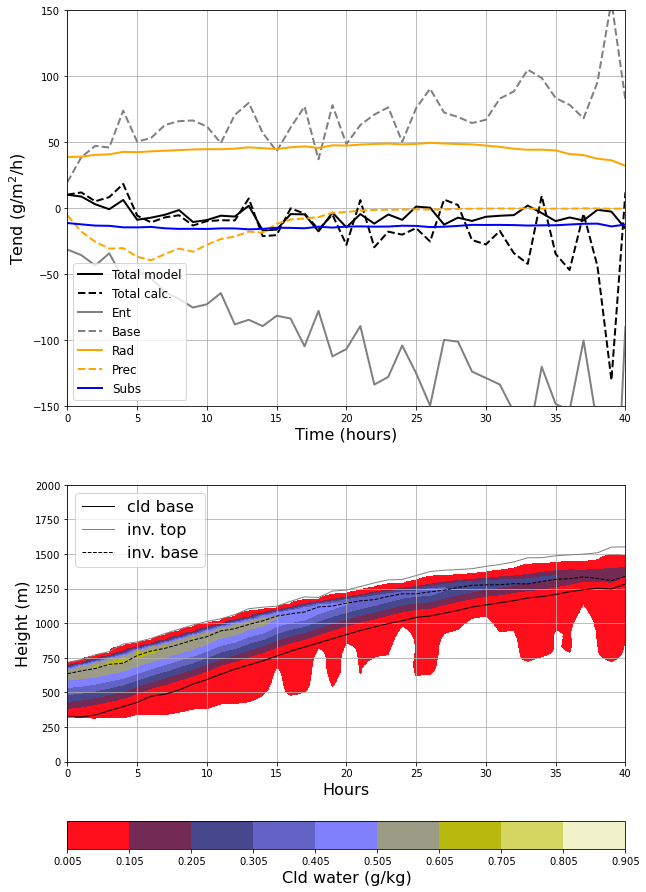

In [10]:
# now we plot
fig, (ax1, ax) = plt.subplots(2,1,figsize=[10, 16])
myfontsize = 16
th = np.arange(nt)

#fig1
ax1.plot(th, lwp_tend_in, color="black", linewidth=2, label='Total model')
ax1.plot(th, total_cal, color="black", linestyle='--', linewidth=2, label='Total calc.')
ax1.plot(th, Ent, color="grey", linewidth=2, label='Ent')
ax1.plot(th, Base, color="grey", linestyle='--', linewidth=2, label='Base')
ax1.plot(th, Rad, color="orange", linewidth=2, label='Rad')
ax1.plot(th, Prec, color="orange", linestyle='--', linewidth=2, label='Prec')
ax1.plot(th, Subs, color="blue", linewidth=2, label='Subs')
#ax1.axhline(y=0, color='black', linestyle='dotted')

ax1.set_ylabel("Tend (g/m$^2$/h)", fontsize=myfontsize)
ax1.set_xlabel("Time (hours)", fontsize=myfontsize)
ax1.set_ylim((-150, 150))
ax1.set_xlim((0,40))
ax1.legend(loc=0, fontsize=12)
ax1.grid(True)

#fig2
var = qc_in*1000.
var = var.T

oax = ax.contourf(th,z,var, cmap = cm.gist_stern, levels = np.arange(0.005,1.,0.1))
make_axis(oax, ax, '', 'Cld water (g/kg)', myfontsize)

ax.plot(th, zb_in, color="black", linewidth=1, label='cld base')
ax.plot(th, zt_in, color="grey", linewidth=1, label='inv. top')
ax.plot(th, zinv_m_in, color="black", linewidth=1, linestyle='--', label='inv. base')
ax.legend(loc=0, fontsize=16)

### Notes
- The LWP budget framework performs reasonably well.
- It works best when the stratocumulus is textbook-like: well-mixed boundary layer, cloud-top cooling driven, negatively skewed vertical velocity.
- When the regime of cumulus-coupled stratocumulus occurs, the fluctuations for "Base" and "Ent" terms become larger. I think of two reasons. First, the fluctuation is caused by the intermittent nature of cumulus convection. Second, both the two terms become  
- The "Base" term and "Ent" term are strongly correlated. Bubbles of moist fluids penetrate into the stratocumulus decks, leading to (1) more moisture supply and (2) stronger entrainment drying/warming. These two processes compensate each other.   

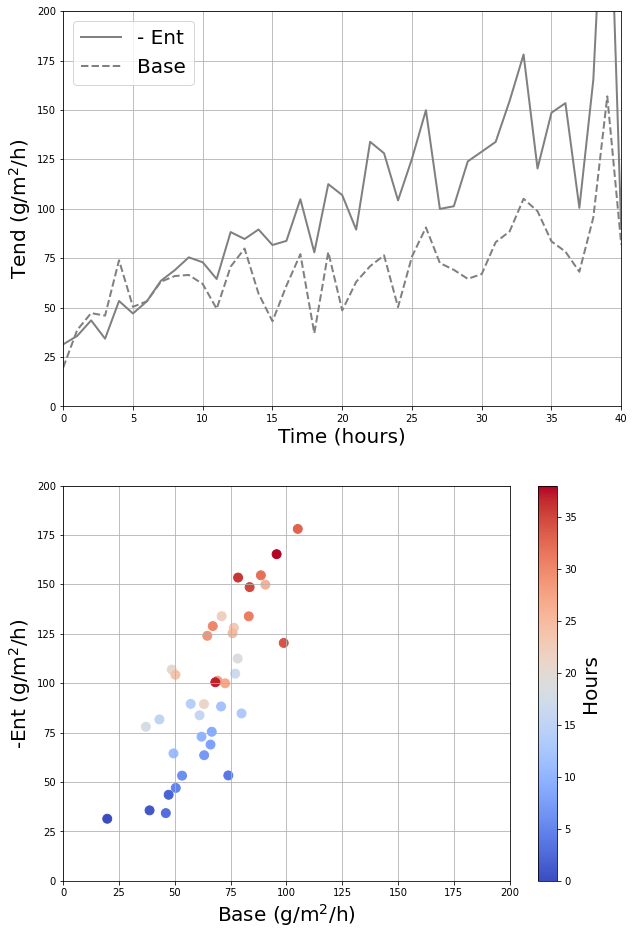

In [173]:
# further look at the correlation between  "Ent" and "Base" term
fig, (ax1, ax2) = plt.subplots(2,1,figsize=[10, 16])
myfontsize = 20
th = np.arange(nt)

#fig1
ax1.plot(th, -Ent, color="grey", linewidth=2, label='- Ent')
ax1.plot(th, Base, color="grey", linestyle='--', linewidth=2, label='Base')
# ax1.plot(th, -Ent - Base, color="black", linestyle='--', linewidth=2, label='-Ent - Base')

ax1.set_ylabel("Tend (g/m$^2$/h)", fontsize=myfontsize)
ax1.set_xlabel("Time (hours)", fontsize=myfontsize)
ax1.set_ylim((0, 200))
ax1.set_xlim((0,40))
ax1.legend(loc=0, fontsize=20)
ax1.grid(True)

#fig2
ioax = ax2.scatter(Base[0:39], -Ent[0:39], c = th[0:39], cmap = cm.coolwarm, s = 80)
# ioax = ax2.scatter(Base[10:39], lwp_tend_in[10:39], c = th[10:39], cmap = cm.coolwarm, s = 80, marker='^')
cbar = fig.colorbar(ioax, ax = ax2)
cbar.set_label("Hours", fontsize=myfontsize)

ax2.set_xlabel("Base (g/m$^2$/h)", fontsize=myfontsize)
ax2.set_ylabel("-Ent (g/m$^2$/h)", fontsize=myfontsize)
ax2.set_ylim((0, 200))
ax2.set_xlim((0, 200))
ax2.grid(True)

plt.show()

## Plot for bar chart

In [67]:
Ent_ave = np.mean(Ent[10:40])
Base_ave = np.mean(Base[10:40])
Rad_ave = np.mean(Rad[10:40])
Prec_ave = np.mean(Prec[10:40])
Subs_ave = np.mean(Subs[10:40])
lwp_tend_in_ave = np.mean(lwp_tend_in[10:40])
total_cal_ave = np.mean(total_cal[10:40])

In [68]:
budget_ave = [Ent_ave, Base_ave, Rad_ave, Subs_ave, Prec_ave, total_cal_ave]
budget_name = ['Entrainment','Moisture flux','Radiation','Subsidence','Precipitation','Net']
color_budget = ['blue','red','red','blue','blue','black']
nb = len(budget_ave)

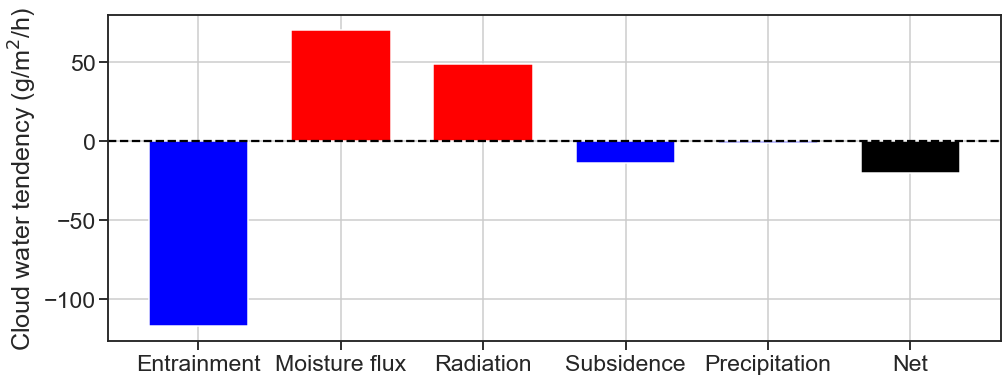

In [69]:
sns.set(context="talk", style="ticks", font_scale=1.4)

fig, ax = plt.subplots(1,1,figsize=(16,6))

ind = np.arange(nb)
width = 0.7

p1 = plt.bar(ind, budget_ave, width, color = color_budget)
plt.axhline(y=0,linestyle='--',color = 'black')

plt.xticks(ind, budget_name)

plt.ylabel('Cloud water tendency (g/m$^2$/h)')

plt.grid(True)
plt.show()

fig.savefig('barplot.png', dpi=fig.dpi)